# Homework #8: Due November 4th, 2021, 11:59pm
## Bayesian Neural Networks

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2021**

**Name: Jiahui Tang**

**Students collaborators: Xin Zeng**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
from autograd.scipy.stats import norm
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param):

        def objective(W, t):
            squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
            if reg_param is None:
                sum_error = np.sum(squared_error)
                return sum_error
            else:
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error

        return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):

        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [3]:
def leap_frog(position_init, momentum_init, step_size, leapfrog_steps, potential_energy, kinetic_energy):        # initialize position
    position = position_init
    # initialize momentum
    momentum = momentum_init

    # compute the gradient of potential energy
    potential_energy_grad = grad(potential_energy)

    # compute the gradient of kinetic energy
    kinetic_energy_grad = grad(kinetic_energy)
    
    momentum, position = np.copy(momentum), np.copy(position)
    # full leap frog steps
    for _ in range(leapfrog_steps - 1):
        # half step update of momentum
        momentum = momentum - step_size/2 * potential_energy_grad(position)

        # full step update of position
        position = position + step_size * kinetic_energy_grad(momentum)

        # half step update of momentum
        momentum = momentum - step_size/2 * potential_energy_grad(position)

        assert not np.any(np.isnan(position))
        assert not np.any(np.isnan(momentum))

    # Reverse momentum
    momentum = -momentum
    return position, momentum

def hmc(position_current, momentum_current, step_size, leapfrog_steps, potential_energy, kinetic_energy, momentum_sampler):

    ### Define total energy
    total_energy = lambda q, p: potential_energy(q) + kinetic_energy(p)

    ### Sample momentum
    # Make sure that the distribution from which you sample the momentum matches 
    # with your kinetic energy function
    momentum_current = momentum_sampler() 

    ### Simulate Hamiltonian dynamics using Leap Frog
    position_proposal, momentum_proposal = leap_frog(position_current, momentum_current, step_size, leapfrog_steps, potential_energy, kinetic_energy)

    # compute total energy in current position and proposal position
    current_total_energy = total_energy(position_current, momentum_current)
    proposal_total_energy = total_energy(position_proposal, momentum_proposal)

    ### Metropolis Hastings Step
    # comute accept probability
    #print(np.exp(current_total_energy - proposal_total_energy))
    accept_prob = np.min([1, np.exp(current_total_energy - proposal_total_energy)])
    #print(accept_prob)
    # accept proposal with accept probability
    if np.random.rand() < accept_prob:
        accept = 1
        position_current = np.copy(position_proposal)
        momentum_current = np.copy(momentum_proposal)
    else:
        accept = 0

    return position_current, momentum_current, accept

## Problem Description: Bayesian Neural Network Regression
In this homework you will explore Bayeisan models for regression with neural networks -- essentially, you will place priors on the network parameters $\mathbf{W}$ and infer the posterior $p(\mathbf{W}|\text{Data})$. These Bayesian models are called ***Bayesian neural networks***. The data for this regression problem is in `HW8_data.csv`. You are provided an implementation of a neural network as well as an example of how to use it -- but feel free to implement your own version!

In [4]:
#read in the data
data = pd.read_csv('HW8_data.csv')
x_train = data['x'].values.reshape((1, -1))
y_train = data['y'].values.reshape((1, -1))
data.head()

,x,y
0,-6.0,-3.380284
1,-5.6,-2.892117
2,-5.2,-2.690059
3,-4.8,-2.040000
4,-4.4,-1.399942


Let's instantiate a neural network with 1-hidden layer, 5-hidden nodes and `relu` activation:

In [5]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

Fit the neural network to the data and visualize the fit.

In [6]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x_train, y_train, params)

Iteration 0 lower bound 1188.2522119587577; gradient mag: 3294.9472005145494
Iteration 100 lower bound 528.2005162282456; gradient mag: 2014.0223481861008
Iteration 200 lower bound 231.7192875708107; gradient mag: 1226.9831178661013
Iteration 300 lower bound 103.99541756891784; gradient mag: 716.7107003654073
Iteration 400 lower bound 55.24716113156888; gradient mag: 376.2334633599828
Iteration 500 lower bound 39.94989749994618; gradient mag: 177.96417730567353
Iteration 600 lower bound 35.60307206137053; gradient mag: 77.1935848441468
Iteration 700 lower bound 34.02585610754244; gradient mag: 38.67687513287843
Iteration 800 lower bound 32.961429361488406; gradient mag: 31.1294903391371
Iteration 900 lower bound 31.989641942996613; gradient mag: 24.752496721932584
Iteration 1000 lower bound 31.082564536611727; gradient mag: 24.616299563320236
Iteration 1100 lower bound 30.155032233758106; gradient mag: 24.248289796695605
Iteration 1200 lower bound 29.21001380959729; gradient mag: 23.69

Iteration 10700 lower bound 2.3765553493366998; gradient mag: 0.7553579421582776
Iteration 10800 lower bound 2.3238459422563555; gradient mag: 0.7228024683428615
Iteration 10900 lower bound 2.2753308343301706; gradient mag: 0.6845211470545377
Iteration 11000 lower bound 2.231249650994413; gradient mag: 0.6413826587050766
Iteration 11100 lower bound 2.1918278044347406; gradient mag: 0.59432252611375
Iteration 11200 lower bound 2.1572058127250546; gradient mag: 0.5444130874954227
Iteration 11300 lower bound 2.1273989093957435; gradient mag: 0.49279021686788194
Iteration 11400 lower bound 2.102281353226884; gradient mag: 0.4406015166810438
Iteration 11500 lower bound 2.0815910694099835; gradient mag: 0.38895956298851503
Iteration 11600 lower bound 2.064950099998062; gradient mag: 0.33889610830740396
Iteration 11700 lower bound 2.05189577096822; gradient mag: 0.2913192491318837
Iteration 11800 lower bound 2.0419171399915643; gradient mag: 0.24697771788258466
Iteration 11900 lower bound 2.0

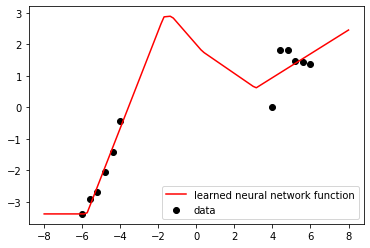

In [7]:
#test x-values
x_test = np.linspace(-8, 8, 100).reshape((1, -1))
#predict on the test x-values
y_test_pred = nn.forward(nn.weights, x_test)
#visualize the function learned by the neural network
plt.scatter(x_train.flatten(), y_train.flatten(), color='black', label='data')
plt.plot(x_test.flatten(), y_test_pred.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

### Part I: Inference for Bayesian Neural Networks Using HMC

1. (**The Bayesian Neural Network Model**) We will implement the following Bayesian model for the data:<br>
\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, 5^2 \mathbf{I}_{D\times D})\\
\mu^{(n)} &= g_{\mathbf{W}}(\mathbf{X}^{(n)})\\
Y^{(n)} &\sim \mathcal{N}(\mu^{(n)}, 0.5^2)\\
\end{align}
where $g_{\mathbf{W}}$ is a neural network with parameters $\mathbf{W}$ represented as a vector in $\mathbb{R}^{D}$ with $D$ being the total number of parameters (including biases).
<br><br>
Implement the log of the joint distribution in `autograd`'s version of `numpy`, i.e. implement $\log \left[p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) \right]$.
***Hint:*** you'll need to write out the log of the various Gaussian pdf's and implement their formulae using `autograd`'s numpy functions.

In [8]:
def log_prior(W):
    W = W.reshape(1, -1)
    cov = np.eye(nn.D)*25
    return -0.5 * (W@np.linalg.inv(cov)@W.T + np.log(np.linalg.det(cov)) + nn.D*np.log(2 * np.pi))

def log_likelihood(W):
    W = W.reshape(1,-1)
    N = y_train.shape[1]
    mu = nn.forward(W, x_train)[0]
    cov = np.eye(N)*0.25
    return -0.5*(y_train-mu)@np.linalg.inv(cov)@(y_train.T-mu.T) - np.log(0.25)*N - 0.5*N*np.log(2 * np.pi) 

2. (**Sample from the Posterior**) Use HMC to sample from the posterior of the Bayesian neural network in Exercise 1 with 1 hidden layer and 5 hidden nodes. Start with the following settings for your sampler:
``` python
params = {'step_size':1e-3, 
          'leapfrog_steps':50, 
          'total_samples':10000, 
          'burn_in':.1, 
          'thinning_factor':2,
          'position_init': nn.weights}
```
  Note that you should initialize with the MLE model, otherwise convergence may be slow. Please feel free to tweak these design choices as you see fit!

In [9]:
params = {'step_size':1e-3, 
       'leapfrog_steps':50, 
       'total_samples':10000, 
       'burn_in':.1, 
       'thinning_factor':2,
       'position_init': nn.weights.flatten()}

#initialize the position vector for HMC sampling with the weights of the trained neural network
initial_position = params["position_init"]
#leap-frog step size
step_size = params["step_size"]
#leap-frog steps
steps = params["leapfrog_steps"]
#number of total samples after burn-in
n_samples = params["total_samples"]
#percentage of samples to burn
burn_in = params["burn_in"]
#thinning factor
thinning_factor = params["thinning_factor"]

In [10]:
D = 16
m = 1
M = m * np.identity(D)

def potential_energy(W):
    return -1 * (np.array(log_likelihood(W) + log_prior(W)).reshape(1,-1)[0][0])

def kinetic_energy(p):
    return 0.5*p.T@np.linalg.inv(M)@p + 0.5*np.log(np.linalg.det(M)) + 0.5*D*np.log(2 * np.pi)

def momentum_sampler():
    return random.normal(0, 1, size=nn.D)

In [11]:
samples = [initial_position]
accepts = 0.

for t in range(n_samples):
    position_current, momentum_current, accept = hmc(samples[-1], momentum_sampler(), step_size, steps, potential_energy, kinetic_energy, momentum_sampler)
    samples.append(position_current)
    accepts += accept
    if t % 500 == 0 and t > 0:
        print('{} iterations, accept rate: {}'.format(t, accepts / (t + 1.)))

accept_rate = accepts / n_samples
samples = np.array(samples)[int(burn_in * n_samples)::thinning_factor]

500 iterations, accept rate: 0.998003992015968
1000 iterations, accept rate: 0.999000999000999
1500 iterations, accept rate: 0.9973351099267155
2000 iterations, accept rate: 0.9945027486256871
2500 iterations, accept rate: 0.9944022391043582
3000 iterations, accept rate: 0.9950016661112963
3500 iterations, accept rate: 0.9954298771779492
4000 iterations, accept rate: 0.9952511872031992
4500 iterations, accept rate: 0.9951121972894912
5000 iterations, accept rate: 0.994001199760048
5500 iterations, accept rate: 0.9927285948009453
6000 iterations, accept rate: 0.9930011664722547
6500 iterations, accept rate: 0.9926165205353022
7000 iterations, accept rate: 0.9928581631195543
7500 iterations, accept rate: 0.9929342754299427
8000 iterations, accept rate: 0.9931258592675916
8500 iterations, accept rate: 0.9932949064815904
9000 iterations, accept rate: 0.9933340739917786
9500 iterations, accept rate: 0.9933691190401011


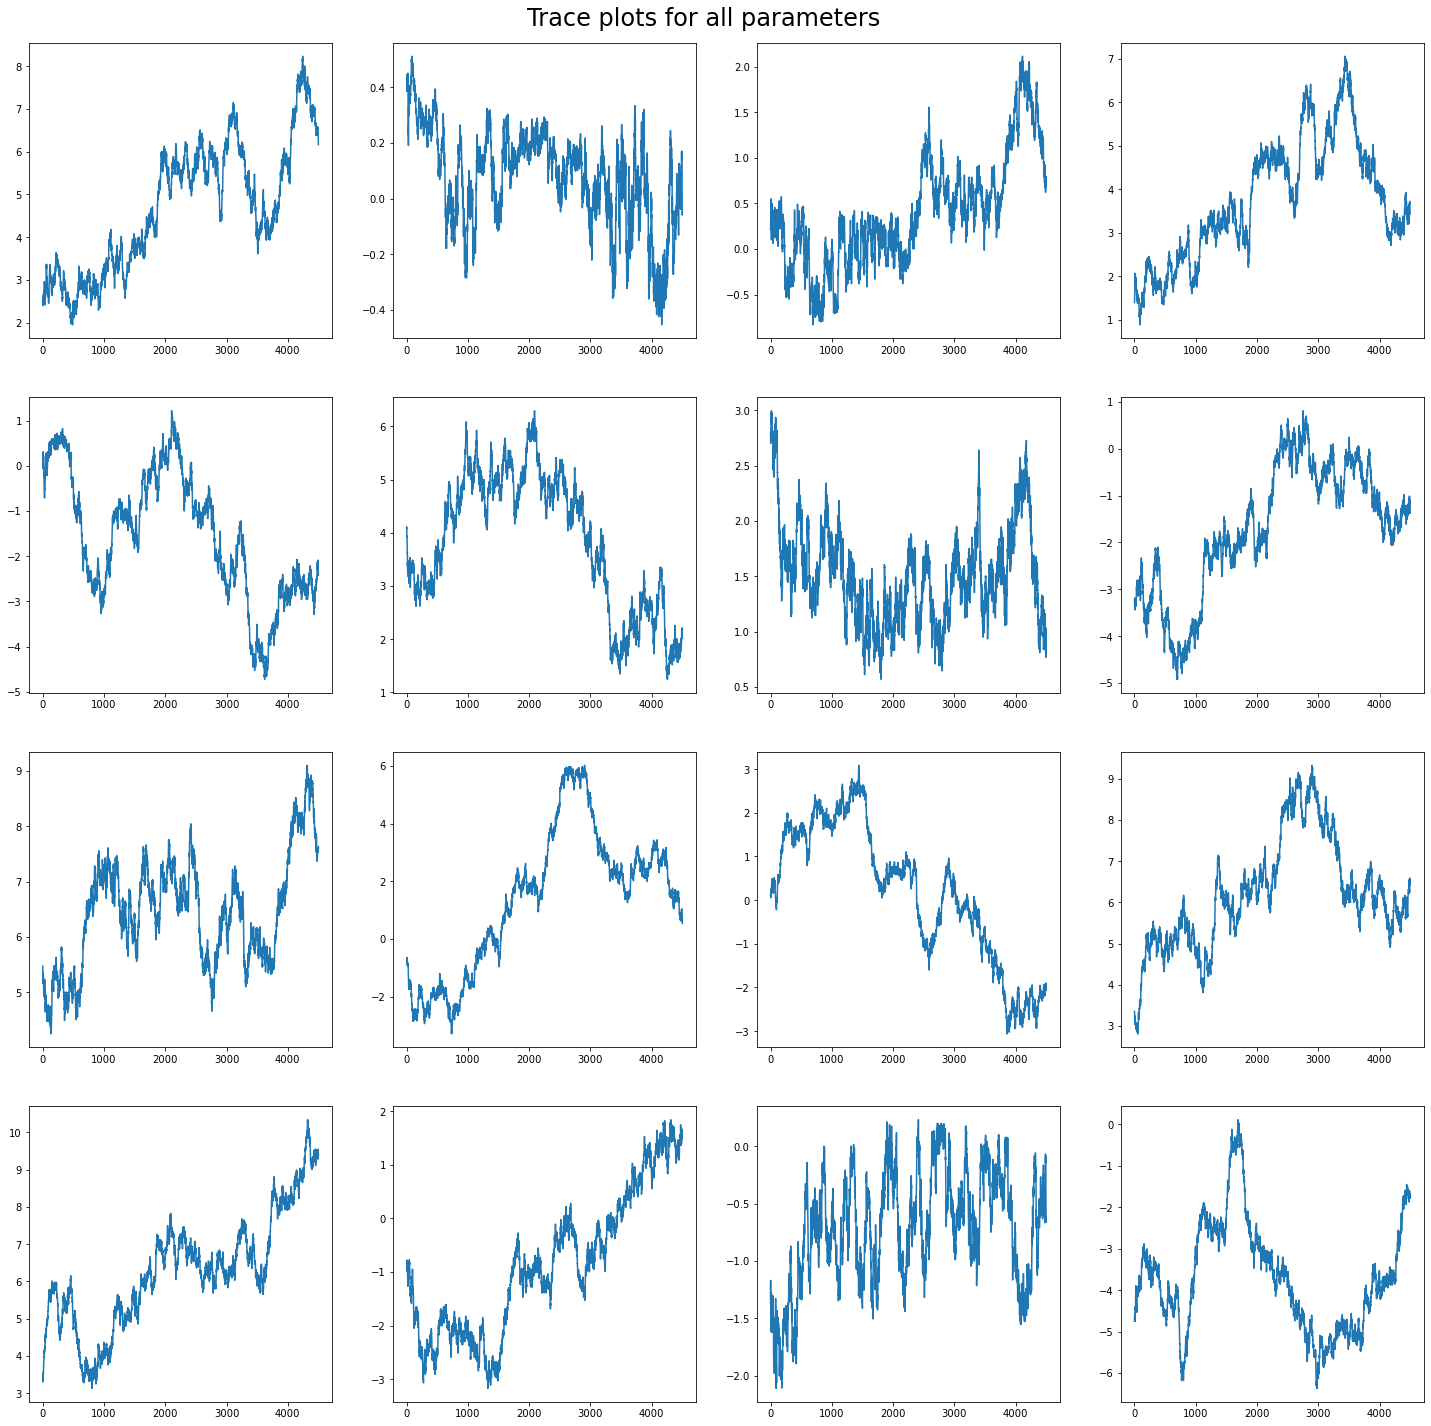

In [12]:
fig, ax = plt.subplots(4, 4, figsize=(25, 25))
for i in range(nn.D):
    ax[i // 4, i % 4].plot(range(samples.shape[0]), np.array(samples)[:, i])
fig.suptitle('Trace plots for all parameters', fontsize=24, y=0.9)
plt.show()

<font color='darkblue'>


From the traceplot, as we could see, it seems none of the parameters are converged. They are all fluctuating ups and downs.

3. (**Visualize the Posterior Predictive**) Visualize 100 samples, randomly selected, from your posterior samples of $\mathbf{W}$, by ploting their predicted values plus a random noise $\epsilon \sim \mathcal{N}(0, 0.5^2)$ at 100 equally spaced x-values between -8 and 8:
``` python 
x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(sample, x_test.reshape((1, -1))) 
y_test += np.random.normal(0, 0.5, size=y_test.shape)
```
  where `sample` is a posterior sample of $\mathbf{W}$.

In [13]:
posterior_samples_index = np.random.choice(len(samples),size=100, replace=False)
posterior_samples = samples[posterior_samples_index]

x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(posterior_samples, x_test.reshape((1, -1))) 
y_test += np.random.normal(0, 0.5, size=y_test.shape)

#95 CI and the mean of the posterior predictives
ub_bayes = np.percentile(y_test, 97.5, axis=0)
lb_bayes = np.percentile(y_test, 2.5, axis=0)
mean_bayes = np.mean(y_test, axis=0)

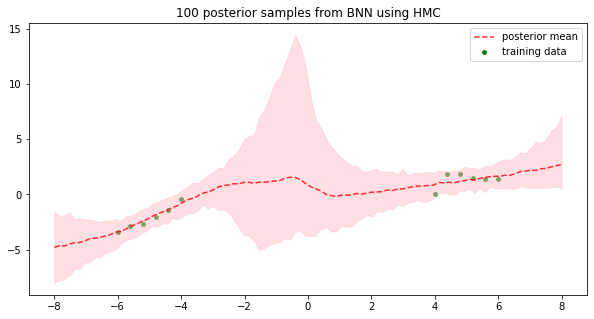

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_train.flatten(), y_train.flatten(), color='green',s=15, alpha=1, label='training data')
ax.plot(x_test.flatten(), mean_bayes.flatten(), '--', color='red', alpha=0.8, label='posterior mean')
ax.fill_between(x_test.flatten(), ub_bayes.flatten(), lb_bayes.flatten(), color='pink', alpha=0.5)

ax.set_title('100 posterior samples from BNN using HMC')
ax.legend(loc='best')
plt.show()

4. (**Model Evaluation**) Discuss the fit of your model to the data. Discuss also what the posterior predictive tell you about the aleatoric and epistemic uncertainty of the model. Are these uncertainties what you'd want (think about want kind of uncertainties you want and where)?

<font color='darkblue'>
    
**Answer**:    

By visualizing the posterior predictive against the observed training data, the model seems fits the data well.

The posterior predictive also looks like giving an accurate accessment of both epistemic and aleatoric uncertainty. In the middle portion where the data is unobserved, the epistemic uncertainty given by posterior predictive is relatively high; and in the part where training data is observed, the aleatoric data is low. 

We want our model to give 1) accurate predictions, 2) realistic estimates of its predictive uncertainty. So that the model can be held accountable by humans in the system. Thus, if the model is likely to make an incorrect decision, we want the uncertainty of this decision to be ideally very high. And thus raising a red flag to the human decision maker to examine or override the decision of this model.


### Part II: Inference for BNNs Using Black-Box Variational Inference with the Reparametrization Trick

1. (**BBVI with the Reparametrization Trick**) Implement BBVI with the reparametrization trick for approximating an arbitrary posterior $p(w| \text{Data})$ by an isotropic Gaussian $\mathcal{N}(\mu, \Sigma)$, where $\Sigma$ is a diagonal matrix. See Lecture #17 or the example code from [autograd's github repo](https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py). 

    **Unit Test:** You shoud check that your implementation is correct by approximating the posterior of the following Bayesian logistic regression model:
\begin{align}
w &\sim \mathcal{N}(0, 1)\\
Y^{(n)} &\sim Ber(\text{sigm}(wX^{(n)} + 10))
\end{align}
  where $w$, $Y^{(n)}$, $X^{(n)}$ are a real scalar valued random variables, and where the data consists of a single observation $(Y=1, X=-20)$.

  The true posterior $p(w | Y=1, X=-20)$ should look like the following (i.e. the true posterior is left-skewed):
<img src="./logistic_posterior.png" style='height:200px;'>
  Your mean-field variational approximation should be a Gaussian with mean around -0.321 and standard deviation around 0.876.

In [15]:
def black_box_variational_inference(logprob, D, num_samples):
    
    """
    Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    code taken from:
    https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
    """

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return np.array(mean), np.array(log_std)

    def negative_gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = np.random.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = negative_gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

In [16]:
def variational_inference(S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = 1
    # when x = -20, y =1
    x_train = np.array([-20])
    y_train = np.array([1])
    
    def log_prior(W):
        return sp.stats.norm.logpdf(W, loc=0, scale=1)
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    #define the log likelihood of binomial, when n = 1
    def log_lklhd(W):
        theta = sigmoid(W * x_train + 10)
        return np.log(theta)

    #define the log joint density
    log_density = lambda w, t: log_lklhd(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 500 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    
    #initialize variational parameters
    # D = 1, hardcoded init value
    init_mean = np.array([-0.3])
    init_log_std = np.array([np.log(0.8)] )
    init_var_params = np.concatenate([init_mean, init_log_std])
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params

In [17]:
### Unit Test
variational_params = variational_inference(S = 3000, max_iteration = 30000, step_size = 1e-4, verbose = True)

Optimizing variational parameters...
Iteration 0 lower bound -1.4652659112990247; gradient mag: 4.1918729959267225
Iteration 500 lower bound -1.191327508264598; gradient mag: 3.553458123809572
Iteration 1000 lower bound -0.9171456304554142; gradient mag: 3.047825846669677
Iteration 1500 lower bound -0.8036258507823921; gradient mag: 2.3534682667553506
Iteration 2000 lower bound -0.6690408420784788; gradient mag: 1.8687639608047855
Iteration 2500 lower bound -0.6288666163386638; gradient mag: 1.239106771495389
Iteration 3000 lower bound -0.6236112933486131; gradient mag: 1.0053995948519168
Iteration 3500 lower bound -0.5485240904284736; gradient mag: 0.645734512866719
Iteration 4000 lower bound -0.5566830414661355; gradient mag: 0.6413358911705404
Iteration 4500 lower bound -0.5177608361812491; gradient mag: 0.3490900650153587
Iteration 5000 lower bound -0.5478910152488189; gradient mag: 0.10851787138174328
Iteration 5500 lower bound -0.5727252788881071; gradient mag: 0.1844531597356004

In [18]:
var_means = variational_params[0]
var_std = np.exp(variational_params[1])
print("Posterior mean: {}".format(var_means))
print("Posterior std: {}".format(var_std))

Posterior mean: -0.5625967376638871
Posterior std: 0.5493862194644582


<font color='darkblue'>
It converged to Posterior mean -0.5625967376641472 and Posterior std  0.5493862194645208 even if I set the initial point to (mean = -0.3, std = 0.8)


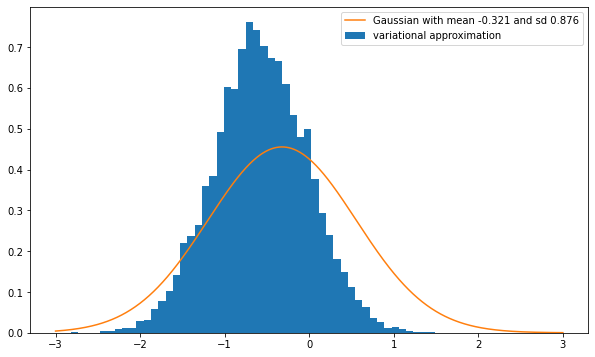

In [19]:
plt.figure(figsize = (10,6))
x = np.linspace(-3,3,1000)
func = lambda x: norm.pdf(x, -0.321, 0.876)
y = func(x)

# getting samples from variational approximation
post_samples = np.random.normal(variational_params[0], np.exp(variational_params[1]), size=10000)

# plot histogram
plt.hist(post_samples, bins = 50, label = "variational approximation", density = True)
plt.plot(x, y, label = "Gaussian with mean -0.321 and sd 0.876")
plt.legend()

2. (**Variational Inference for BNNs**) For the Bayesian model you implemented in Exercise 1 and 2, use BBVI with the reparametrization trick to approximate the posterior of the Bayesian neural network with a mean-field Gaussian variational family (i.e. an isotropic Gaussian). Please set learning rate and maximum iteration choices as you see fit!

In [20]:
### adapted from lecture 17 notes ###

def black_box_variational_inference(logprob, D, num_samples):
    
    """
    Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    code taken from:
    https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
    """

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params


def variational_inference(Sigma_W, sigma_y, y_train, x_train, forward, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D
    
    #define the log prior on the model parameters
    def log_prior(W):
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        return log_p_W

    #define the log likelihood
    def log_lklhd(W):
        S = W.shape[0]
        constant = (- np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
        exponential = -0.5 * sigma_y**-2 * np.sum((y_train.reshape((1, 1, N)) - forward(W, x_train))**2, axis=2).flatten()
        return constant + exponential

    #define the log joint density
    log_density = lambda w, t: log_lklhd(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 500 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    
    #initialize variational parameters
    # set initial mean to be NN weights
    
    init_mean = nn.weights.reshape((nn.D, ))
    init_var = np.ones(init_mean.shape) * -100
    init_var_params = np.hstack((init_mean, init_var))
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params

In [21]:
Sigma_W = 5**2 * np.eye(nn.D)
sigma_y = 0.5**2
N = 12
S = 100
D = nn.D
step_size = 1e-3
max_iteration = 30000
verbose = True


#approximate posterior with mean-field gaussian
variational_params = variational_inference(Sigma_W, sigma_y, y_train, x_train, nn.forward, S, max_iteration, step_size, verbose)

Optimizing variational parameters...
Iteration 0 lower bound -1629.6712320283864; gradient mag: 4.013795501410748
Iteration 500 lower bound -1621.6232388816334; gradient mag: 4.011025512133165
Iteration 1000 lower bound -1613.5545066257364; gradient mag: 4.010085970025186
Iteration 1500 lower bound -1605.4813377436974; gradient mag: 4.049612036515778
Iteration 2000 lower bound -1597.424800215675; gradient mag: 15.281049063371531
Iteration 2500 lower bound -1589.3773015653182; gradient mag: 4.214111709526817
Iteration 3000 lower bound -1581.3406692699677; gradient mag: 4.004532836340817
Iteration 3500 lower bound -1573.3112031884114; gradient mag: 4.003346614625546
Iteration 4000 lower bound -1565.28742794034; gradient mag: 4.006021662755406
Iteration 4500 lower bound -1557.2686124142567; gradient mag: 8.557583435836406
Iteration 5000 lower bound -1549.2524925194468; gradient mag: 4.134993595559938
Iteration 5500 lower bound -1541.2398099018542; gradient mag: 4.001794791749025
Iteration

3. (**Visualize the Posterior Predictive**) Visualize 100 samples $\mathbf{W}^s$ from your approximate posterior of $\mathbf{W}$ by ploting the neural network outputs with weight $\mathbf{W}^s$ plus a random noise $\epsilon \sim \mathcal{N}(0, 0.5^2)$ at 100 equally spaced x-values between -8 and 8:
``` python 
x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(sample, x_test.reshape((1, -1))) 
y_test += np.random.normal(0, 0.5, size=y_test.shape)
```
  where `sample` is a sample from the approximate posterior of $\mathbf{W}$.

In [22]:
var_means = variational_params[:D]
var_variance = np.diag(np.exp(variational_params[D:])**2)
posterior_samples = np.random.multivariate_normal(var_means, var_variance, size=100)

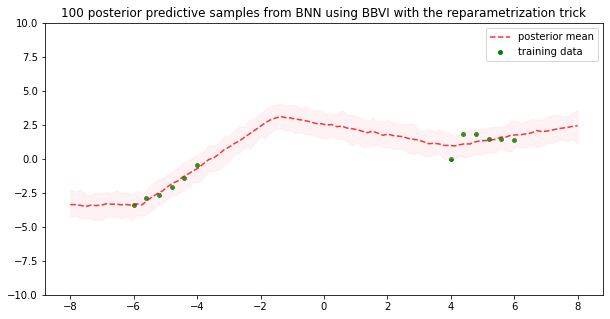

In [23]:
total_samples = len(posterior_samples)

x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(posterior_samples, x_test.reshape((1, -1))) 
y_test += np.random.normal(0, 0.5, size=y_test.shape)

#compute the 95 percentiles and the mean of the posterior predictives
ub_bayes = np.percentile(y_test, 97.5, axis=0)
lb_bayes = np.percentile(y_test, 2.5, axis=0)
mean_bayes = np.mean(y_test, axis=0)


#visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_train.flatten(), y_train.flatten(), color='green', s=15, alpha=1, label='training data')
ax.plot(x_test.flatten(), mean_bayes.flatten(), '--', color='red', alpha=0.8, label='posterior mean')
ax.fill_between(x_test.flatten(), ub_bayes.flatten(), lb_bayes.flatten(), color='pink', alpha=0.2)
ax.set_ylim((-10, 10))
ax.set_title('100 posterior predictive samples from BNN using BBVI with the reparametrization trick')
ax.legend(loc='best')
plt.show()

4.  (**Model Evaluation**) Discuss the fit of your model to the data. Discuss also what the posterior predictive tell you about the aleatoric and epistemic uncertainty of the model. Are these uncertainties what you'd want (think about want kind of uncertainties you want and where)?

<font color='darkblue'>
    
**Answer**:    

By visualizing the posterior predictive against the observed training data, the model seems fits the data well.

However, the posterior predictive using BBVI with mean field assumption Gaussian variational family does not look like giving an accurate accessment of both epistemic and aleatoric uncertainty. In the middle portion where the data is unobserved, the epistemic uncertainty given by posteriro predictive is not high, which is more or less similarly t the part where training data is observed. Both the epistemic and the aleatoric uncertainty is low, showing the model is quite certain about its posterior prediction.

As said in above, we want our model to give 1) accurate predictions, 2) realistic estimates of its predictive uncertainty. So that the model can be held accountable by humans in the system. Thus, if the model is likely to make an incorrect decision, we want the uncertainty of this decision to be ideally very high. And thus raising a red flag to the human decision maker to examine or override the decision of this model. However, in BBVI, this is not shown.


### Part III: Comparison 

1. (**Model Evaluation**) Compare the posterior predictive visualization from BBVI with the reparametrization trick to the one you obtained using HMC. Can you say whether or not your posterior approximation is good? How does approximating the posterior effect our estimation of epistemic and aleatoric uncertainty?

<font color='darkblue'>
    
**Answer**:  
    
To quantify as a good posterior approximation, most of us in the community agree that we want models that 1) makes accurate predictions 2) gives realistic estimates of its prective uncertainty. So that the model can be held- accountable by humans in the system. There are a number of subcomunities in ML that focus on studying the social impact of machine learning models as well as how to design models whose negative impact can be mitigated. If the model is likely to make an incorrect decision, we want the uncertainty of this decision to be ideally very high. And thus raising a red flag to the human decision maker to examine or override the decision of this model.

From the above posterior predictive visualization from BBVI with the reparametrization trick to the one we obtained in question 1 using HMC, we can see that:
    
1. HMC sampler is far from converged, however, we were still able to produce posterior predictives that aligned well with our observed data, and had a good epistemic and aleatoric uncertainty. We can say this posterior approximation is **good**.
2. BBVI sampler are also able to produce posterior predictives that aligned well with our observed data, however, it does not provide a good epistemic and aleatoric uncertainty. The epistemic uncertainty in the region where the data is unobserved is too low. We can say this posterior approximation is **not as good** as expected.
3. A poor posterior approximation does not imply poor posterior predictive.
    
As lecture 19 suggests, in fact, a number of works are showing that by capturing a little piece (if it is the right piece) of the true posterior of a BNN, we are able to capture most of the variations in the posterior predictive.

2. (**Quality of Posterior Vs Quality of Posterior Predictive**) Based on your convergence diagnostics of your HMC sampler, do you believe that you've obtained a set of representative samples from the BNN posterior? Why or why not? 

  Based on your understanding of BNN posteriors, do you believe that a mean-field Gaussian is a good approximation of the BNN posterior? Why or why not?

  Which set of samples, HMC or VI, do you believe better captures the BNN posterior?

  Based on the empirical results from above, do you believe there is a clear positive relationship between posterior approximation and quality of posterior predictive uncertainties - i.e. is it true that the more I capture of the BNN posterior the beter the quality of my posterior predictive uncertainties?

<font color='darkblue'>
    
**Answer:**

1. Based on the convergence diagnostics of the HMC sampler, I do not believe that I've obtained a set of representative samples from the BNN posterior, as the visualization shows none of the parameters has converged. 
    
2. Based on my understanding of BNN posteriors, I also do not believe that a mean-field Gaussian is a good approximation of the BNN posterior. As mean field Gaussian only captures one mode in the posterior, and assume joint posterior could be factorized completely. The variational family is not modeling correlations between parameters. However, as we could imagine, in a BNN, or in NN in general, the shape of NN in high dimension could be so complex(e.g. multiple modes) that using mean field gaussian could be too naive to capture its complexity.

3. I believe HMC better captures the BNN posterior. As the posterior of a neural network is multimodal and very complex, posing challenges for samplers who struggles with jumping from mode to mode. Thus, using BBVI and mean field gaussian may not be enough to capture the complexity of the posterior. It forego the accuracy and complexity for computation efficiency. It forego the possibility of an exact match from onset. We admit right away our approximate dist (variational dist) will never probably capture the target distribution. But the cause is unfront - due to variational distribution are not as complex.

    
4. Based on the empirical results from above, I do not think there is a clear positive relationship between posterior approximation and quality of posterior predictive uncertainties. Even a 'poor' approximation of the posterior of a BNN can give us a superior looking posterior predictive (e.g. in BBVI). 
    

3. (**Speed and Scalability**) Compare the two inference methods, HMC and BBVI, and discuss the scalability of each with respect to the number of model parameters and number of data points (how does increasing the number of model parameters or the number of data points affect each inference method?). 

<font color='darkblue'>
    
**Answer:**
    
        
As the training data for BNNs are typically large, this makes gradient-based samplers like HMC extremely inefficient - in every leap-frog iteration of HMC, the gradient requires an evaluation over the entire training data set. Thus we should go for HMC if we want high accuracy and we have computational power; otherwise, we could go for BBVI.
    
In short,
* BBVI has high scalability w.r.t the number of model parameters and number of data points. It is computationally easy and quick
* HMC does not has good scalability due to the fact of slow gradient computation in each step of its leap frog.

    
And from the empirical result above, we see that could obtain good predictive distribution (i.e. distribution with good alleatoric and epistemic uncertainty) by just capturing two dimensional subspace of the very complex posterior of a BNN. It gives us hope that our approximate inference method for deep beyesian models can be both scalable and useful if we can be very thoughtful about which features of the true posterior we need to capture in our variational posterior.